## Dataset Notes

There are diffrent Imaging Methods use in the Dataset, but labelt in the Image name.

Alzheimers has only one sort of images labelt mild & very mild

in "normal" these are called non_xxx

in parkinson these are 
Reg_...
but very few


In [1]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from load_data import load_dataset, split_dataset, load_specific_dataset
from torch.utils.data import DataLoader


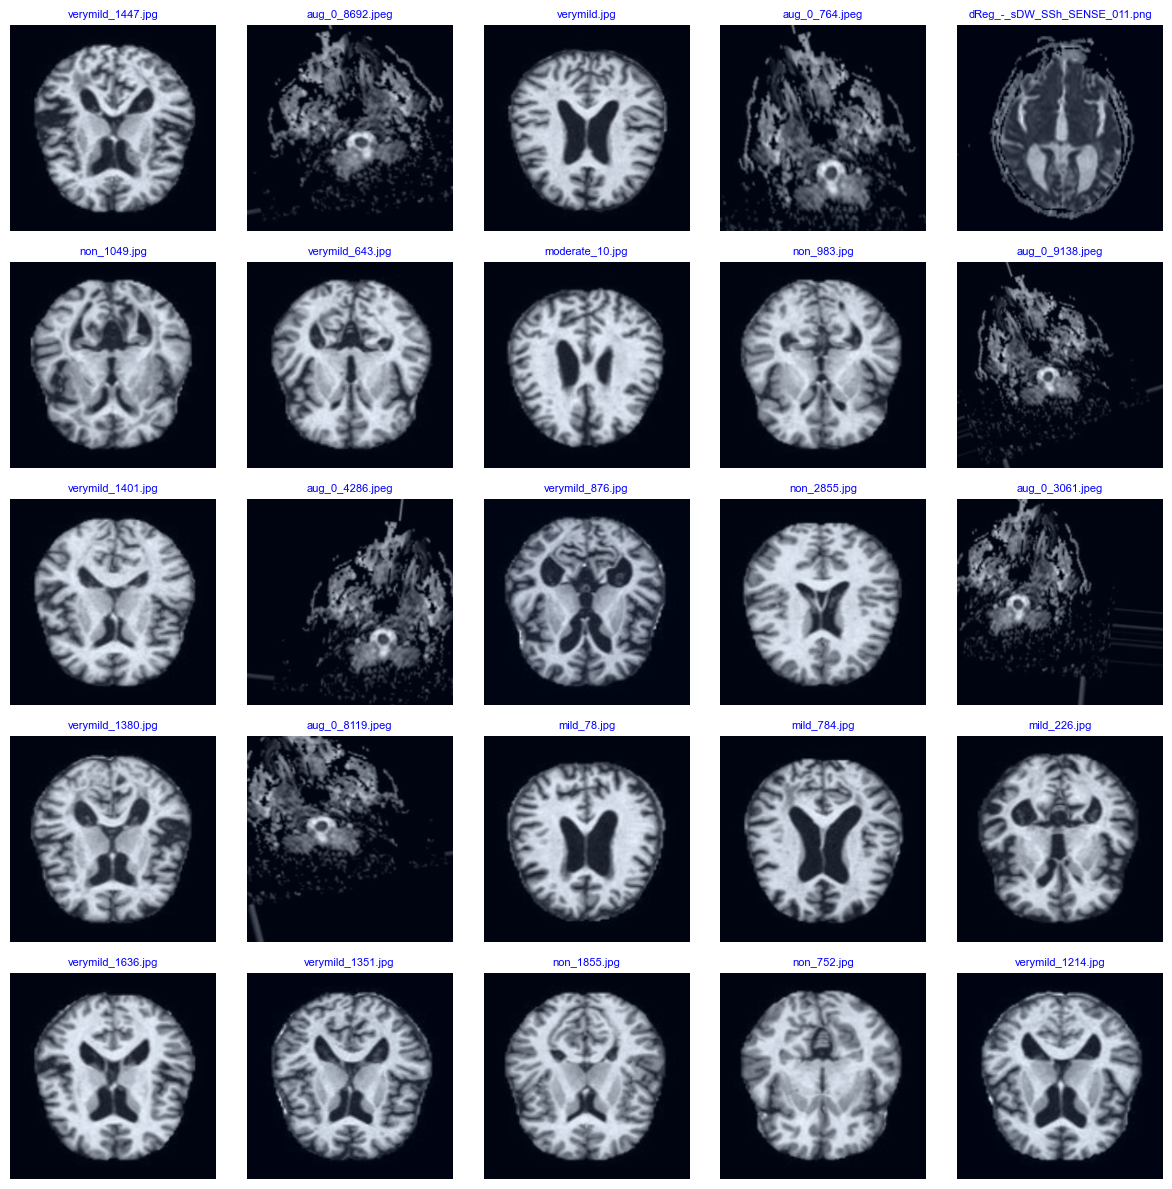

In [11]:
#-------------- Bilder anschauen -----------------
full_dataset = load_dataset()
# Select random images from the dataset
random_indices = random.sample(range(len(full_dataset)), 25)
images = [full_dataset[i][0] for i in random_indices]  # Extract only the image tensor
filenames = [os.path.basename(full_dataset.samples[i][0]) for i in random_indices]  # Get filenames

# Display the images with filenames in a 5x5 grid
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    # Convert image to displayable format
    img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for plt

    # Normalize to [0, 1]
    if img.min() < 0 or img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min())  

    ax.imshow(img)
    ax.axis('off') 
    ax.set_title(filenames[i], fontsize=8, color='blue')

plt.tight_layout()
plt.show()


In [2]:
data_dir = 'data'
dataset = load_dataset()

train_dataset, val_dataset, test_dataset = split_dataset(dataset)

# Dataloader erstellen
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


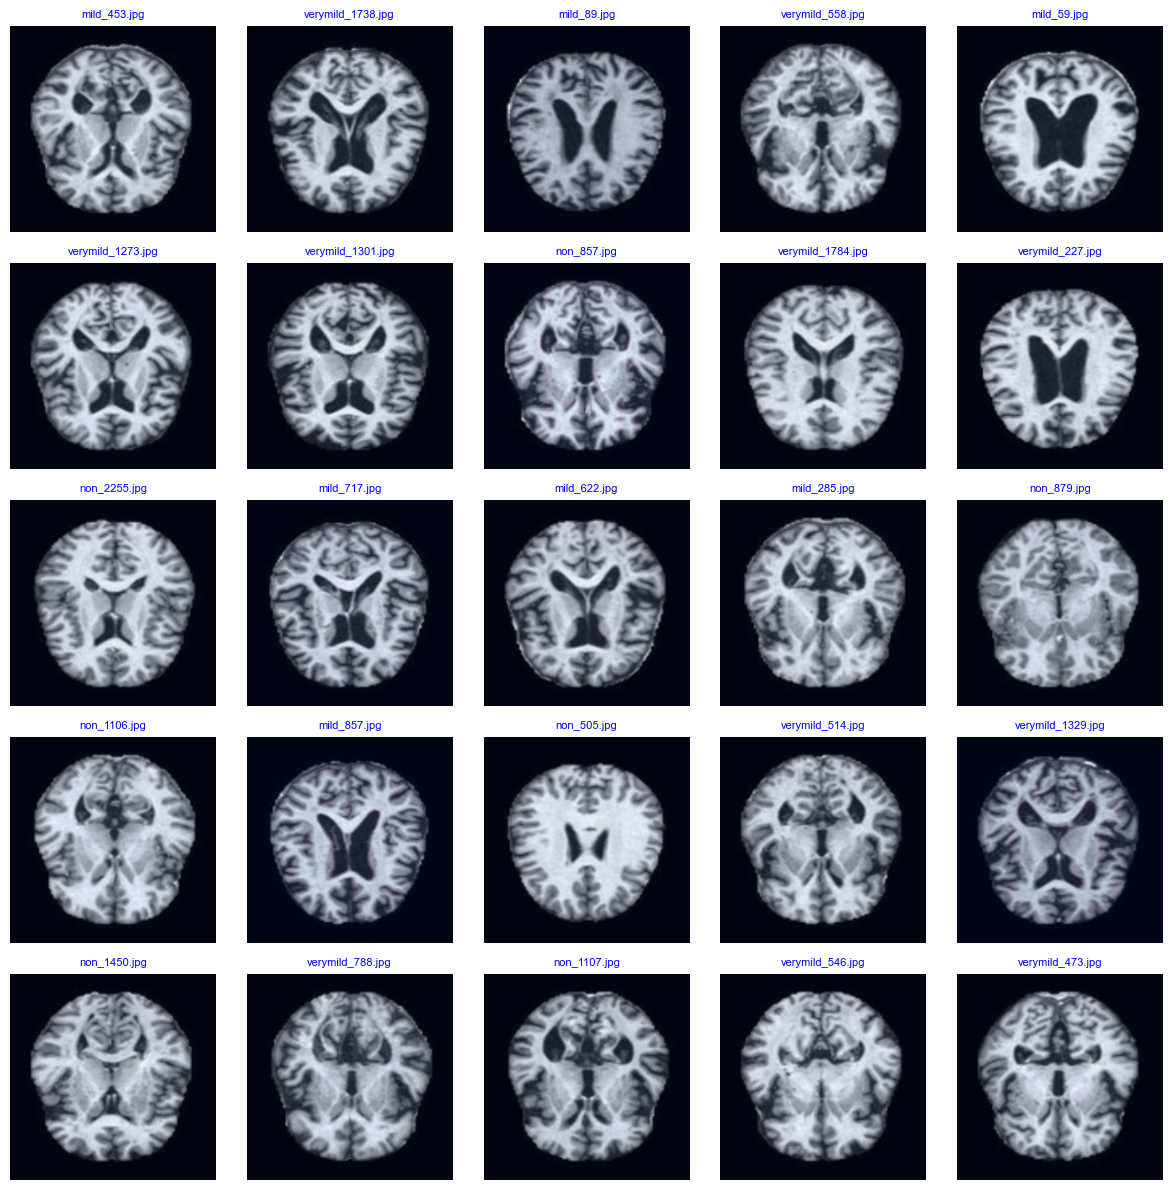

In [13]:
# Select random images from the dataset
random_indices = random.sample(range(len(dataset)), 25)
images = [dataset[i][0] for i in random_indices]  # Extract only the image tensor
filenames = [os.path.basename(dataset.samples[i][0]) for i in random_indices]  # Get filenames

# Display the images with filenames in a 5x5 grid
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    # Convert image to displayable format
    img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for plt

    # Normalize to [0, 1]
    if img.min() < 0 or img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min())  

    ax.imshow(img)
    ax.axis('off') 
    ax.set_title(filenames[i], fontsize=8, color='blue')

plt.tight_layout()
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, num_classes=3):  # 3 Klassen: normal, Alzheimer, Parkinson
        super(CNNModel, self).__init__()
        self.layers = nn.Sequential(
            # Convolutional-Schicht: 3 Eingabekanäle (RGB), 16 Filter, 5x5 Kernel
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Convolutional-Schicht: 16 Eingabekanäle, 32 Filter, 3x3 Kernel
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            
            # Fully Connected-Schicht
            nn.Linear(16 * 56 * 56, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout für Regularisierung
            
            # Fully Connected-Schicht, die zu Klassen führt
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

# Create the model and use an optimizer with a tuned learning rate
model = CNNModel(num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with an initial learning rate
criterion = nn.CrossEntropyLoss()  # loss function for classification

# Model summary for confirmation
from torchsummary import summary
summary(model, (3, 224, 224))
model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]           2,320
              ReLU-5         [-1, 16, 112, 112]               0
         MaxPool2d-6           [-1, 16, 56, 56]               0
           Flatten-7                [-1, 50176]               0
            Linear-8                  [-1, 256]      12,845,312
              ReLU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                    [-1, 3]             771
Total params: 12,848,851
Trainable params: 12,848,851
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Fo

CNNModel(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=50176, out_features=256, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=256, out_features=3, bias=True)
  )
)

In [13]:
# Gerät definieren (CPU oder GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Modell initialisieren
model = CNNModel(num_classes=3).to(device)

# Loss und Optimizer definieren
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Listen zum Speichern der Verluste und Genauigkeiten
train_losses = []
val_losses = []
val_accuracies = []


In [14]:
num_epochs = 20
for epoch in range(num_epochs):
    # Training
    model.train()  # Setze das Modell in den Trainingsmodus
    running_loss = 0.0
    print(f'start: {len(train_loader)}')
    i=0
    for images, labels in train_loader:
        i=i+1
        print(i)
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Gradienten zurücksetzen
        
        # Vorwärtsdurchlauf
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Rückwärtsdurchlauf und Optimierung
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Durchschnittlicher Trainingsverlust für diese Epoche
    print('done with for schleife')
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validierung
    model.eval()  # Modell in den Evaluierungsmodus setzen
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # Wir benötigen keine Gradienten für die Validierung
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Vorwärtsdurchlauf
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Addiere den Verlust
            val_loss += loss.item()
            
            # Genauigkeit berechnen: Finde die maximale Logit (Vorhersage)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Durchschnittlicher Validierungsverlust und Genauigkeit
    val_loss = val_loss / len(val_loader)
    accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}')

start: 167
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
done with for schleife
Epoch [1/20], Loss: 0.5847, Val Loss: 0.4196, Val Accuracy: 0.8102
start: 167
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

In [17]:
# Nach dem Training: Testen des Modells
model.eval()
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Vorhersage und Verlustberechnung
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Vorhersagen und Labels für Confusion Matrix speichern
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Testgenauigkeit und -verlust berechnen
test_accuracy = 100 * correct / total
test_loss = test_loss / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.2018, Test Accuracy: 92.60%


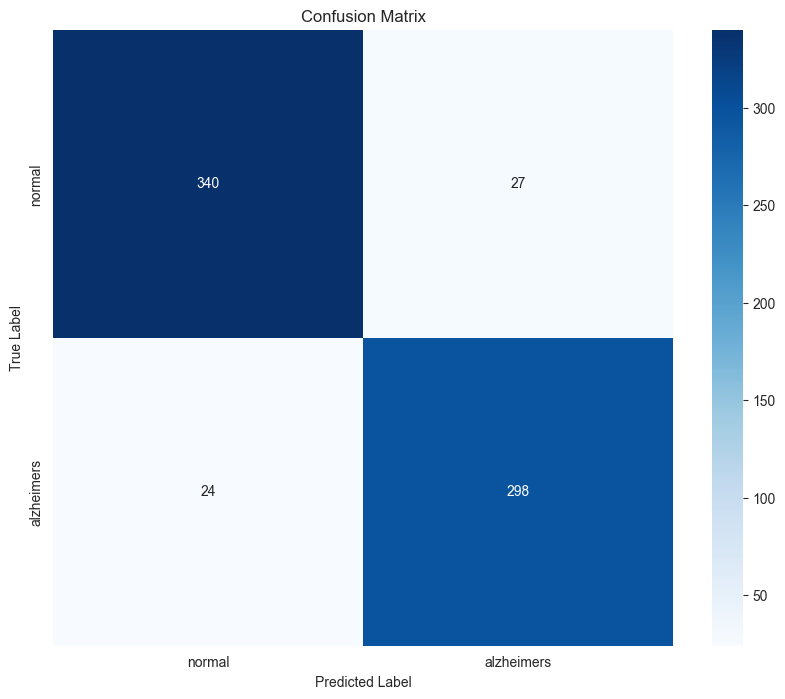

In [18]:
class_names = ['normal', 'alzheimers']

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [20]:
torch.save(model.state_dict(), 'CNN_3L_selected_train')